# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# Inspired by https://stackoverflow.com/a/8856387/5353461
import inspect
import re

def describe(arg):
    frame = inspect.currentframe()
    callerframeinfo = inspect.getframeinfo(frame.f_back)
    try:
        context = inspect.getframeinfo(frame.f_back).code_context
        caller_lines = ''.join([line.strip() for line in context])
        m = re.search(r'describe\s*\((.+?)\)$', caller_lines)
        if m:
            caller_lines = m.group(1)
            position = str(callerframeinfo.filename) + "@" + str(callerframeinfo.lineno)

            # Add additional info such as array shape or string length
            additional = ''
            if hasattr(arg, "shape"):
                additional += "[shape={}]".format(arg.shape)
            elif hasattr(arg, "__len__"):  # shape includes length information
                additional += "[len={}]".format(len(arg))

            # Use str() representation if it is printable
            str_arg = str(arg)
            str_arg = str_arg if str_arg.isprintable() else repr(arg)

            print(position, "describe(" + caller_lines + ") = ", end='')
            print(arg.__class__.__name__ + "(" + str_arg + ")", additional)
        else:
            print("Describe: couldn't find caller context")

    finally:
        del frame
        del callerframeinfo

In [2]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [3]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [4]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

torch.manual_seed(0)  # For reproducability

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    transform = transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                            #         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            #                               std=[0.229, 0.224, 0.225]),        
                                   ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
img_size = 32  # Size of both x and y dimensions

# Define function hyperparameters
batch_size = 16
image_channels = 3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

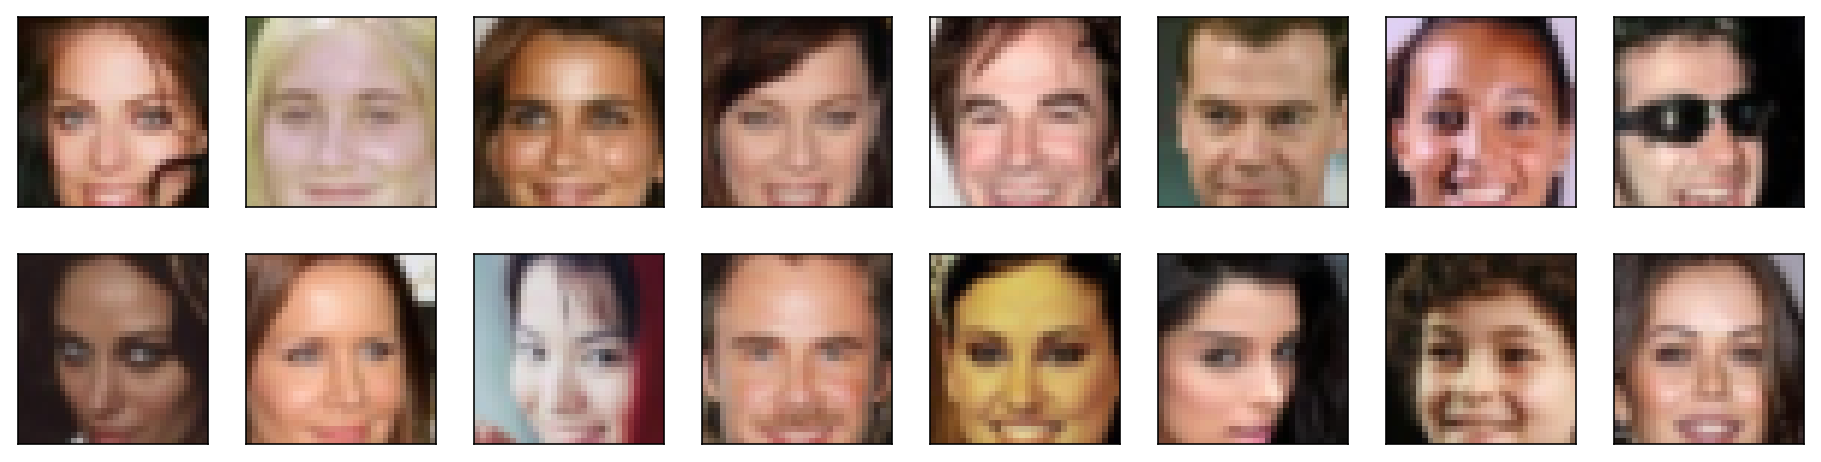

In [7]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(16, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    
    min, max = feature_range
    
    x = min + x * (max - min)
    return x

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9373)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# helper conv function
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, transpose=False):
    """
    Creates a convolutional block, with optional batch normalization.
    :param in_channels:  input volume depth
    :param out_channels: output volume depth
    :param batch_norm:   False for no batch norm
    :param transpose:    True for fractional convolution
    """

    layers = []
    
    if transpose:
        conv_module = nn.ConvTranspose2d
    else:
        conv_module = nn.Conv2d

    conv_layer = conv_module(in_channels, out_channels, 
                             kernel_size, stride, padding, bias=(not batch_norm))
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):
   
    def __init__(self, initial_channels=32):
        """
        Initialize the Discriminator Module
        :param initial_channels: The depth of the first convolutional layer
        
        initial_channels depth is progressively doubled by each following layer
        No batch orm on the first layer
        """
        super(Discriminator, self).__init__()

        # Usage of dropout in convolutional GANs with batch norm?
        # https://stats.stackexchange.com/q/401962/162527
        # self.dropout = nn.Dropout(p=0.3) 
        
        num_conv_layers = 3
        
        # Get # of channels of each conv block
        conv_channels = [initial_channels * 2**scaling for scaling in (range(num_conv_layers))]
        
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(conv_block(image_channels, conv_channels[0], batch_norm=False))
        for ch_in, ch_out in zip(conv_channels[:-1], conv_channels[1:]):  
            self.conv_layers.append(conv_block(ch_in, ch_out))

        self.conv_out_volume = conv_channels[-1] * (img_size // 2**(num_conv_layers)) ** 2    
        self.fc = nn.Linear(self.conv_out_volume, 1)
  
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """

        batches = x.shape[0]
        
        for conv in self.conv_layers:
            x = conv(x)
            x = F.leaky_relu(x, negative_slope=0.2)
        
        x = x.reshape(batches, -1)
        return self.fc(x)  # No sigmoid applied

    
# Test
d = Discriminator()
# print(d)
o = d(torch.rand(10, 3, 32, 32));
# describe(o.shape)

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, out_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param out_dim: The layers of the last, *non-output* convolutional layer
        """

        super(Generator, self).__init__()
        
        self.initial_dim = 4  # Size of both x and y dimension of first conv volume 
        
        num_conv_layers = 3  # Includes the final layer which outputs image_channels # of channels       
        self.initial_channels = out_dim * 2**(num_conv_layers-1)
        self.first_conv_volume = self.initial_dim**2 * self.initial_channels
        
        # Convert latent space to small spatial extent convolutional representation with many feature maps
        self.fc = nn.Linear(z_size, self.first_conv_volume)
        
        # Get # of channels of *non-output* conv blocks
        conv_channels = [out_dim * 2**scaling for scaling in reversed(range(num_conv_layers))]
        
        self.conv_layers = nn.ModuleList()
        for ch_in, ch_out in zip(conv_channels[:-1], conv_channels[1:]):  
            self.conv_layers.append(conv_block(ch_in, ch_out, transpose=True))

        # Output conv layer has no batch norm
        self.conv_layers.append(conv_block(conv_channels[-1], image_channels, batch_norm=False, transpose=True))
            
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """

        x = self.fc(x)
        x = x.reshape(-1, self.initial_channels, self.initial_dim, self.initial_dim)
        for conv_layer in self.conv_layers[:-1]:  # All but last conv block
            x = conv_layer(x)
            x = F.leaky_relu(x, negative_slope=0.2)
    
        x = self.conv_layers[-1](x)  # Final layer
        return torch.tanh(x)
    
# Test
g = Generator(100)
out = g(torch.rand(10, 100))
# print(g)
# describe(out.shape)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from torch.nn import init

def weights_init_normal(m, mean=0, std=0.02):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """

    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and ('Conv' in classname or 'Linear' in classname):
        init.normal_(m.weight.data, mean, std)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif 'BatchNorm2d' in classname:
        init.normal_(m.weight.data, 1.0, std)
        init.constant_(m.bias.data, 0.0)

g.apply(weights_init_normal);  # apply weights_init_normal function

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size, verbose=True):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, out_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    if verbose:
        print(D)
        print()
        print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(64,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    
device = 'gpu' if torch.cuda.is_available() else 'cpu'

D.to(device)
G.to(device);

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
   param, D_out: discriminator logits
   param, smooth: value to assign to labels, or 0.9 if True
   return: real loss'''

    batch_size = D_out.shape[0]
    # label smoothing
    if smooth:  # smooth, real labels = 0.9 or as given by smooth parameter
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
   param, D_out: discriminator logits
   return: fake loss'''

    batch_size = D_out.shape[0]
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

lr=0.0003
betas=(0.1, 0.999)

d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=betas)
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=betas)

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
# Keep track of loss and generated, "fake" samples
# Global so that training can be interrupted and stats still obtained
samples = []
losses = []

def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 16
    fixed_z = torch.Tensor(sample_size, z_size).uniform_(-1, 1).to(device)

    printings = 0  ########## for debug
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.shape[0]
            real_images.to(device)
            real_images = scale(real_images)

            # =============
            # Descriminator
            # =============
            d_optimizer.zero_grad()
            
            real_losses = real_loss(D(real_images), smooth=True)
            
            z = torch.Tensor(sample_size, z_size).uniform_(-1, 1).to(device)
            fake_images = G(z)
            fake_losses = fake_loss(D(fake_images))
            
            d_loss = real_losses + fake_losses

            # Backprop
            d_loss.backward()
            d_optimizer.step()

            # =============
            # Generator
            # =============
            g_optimizer.zero_grad()
            
            z = torch.Tensor(sample_size, z_size).uniform_(-1, 1).to(device)
            fake_images = G(z)
            
            g_loss = real_loss(D(fake_images), smooth=False)
            
            # Backprop
            g_loss.backward()
            g_optimizer.step()

            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                printings += 1
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
#                 print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
#                         epoch+1, n_epochs, d_loss.item(), g_loss.item()))
                print('{:3d} Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    printings, epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

  1 Epoch [    1/   20] | d_loss: 1.6866 | g_loss: 0.7254
  2 Epoch [    1/   20] | d_loss: 0.8301 | g_loss: 2.8839
  3 Epoch [    1/   20] | d_loss: 1.4123 | g_loss: 0.8827
  4 Epoch [    1/   20] | d_loss: 0.8432 | g_loss: 2.9896
  5 Epoch [    1/   20] | d_loss: 0.8980 | g_loss: 3.4730
  6 Epoch [    1/   20] | d_loss: 1.4897 | g_loss: 3.1271
  7 Epoch [    1/   20] | d_loss: 0.9749 | g_loss: 2.7450
  8 Epoch [    1/   20] | d_loss: 1.0827 | g_loss: 1.8614
  9 Epoch [    1/   20] | d_loss: 0.7347 | g_loss: 1.4361
 10 Epoch [    1/   20] | d_loss: 1.2311 | g_loss: 1.6660
 11 Epoch [    1/   20] | d_loss: 1.5110 | g_loss: 0.6495
 12 Epoch [    1/   20] | d_loss: 1.3185 | g_loss: 1.2035
 13 Epoch [    1/   20] | d_loss: 1.2401 | g_loss: 1.8594
 14 Epoch [    1/   20] | d_loss: 1.2098 | g_loss: 0.6918
 15 Epoch [    1/   20] | d_loss: 1.3066 | g_loss: 1.3896
 16 Epoch [    1/   20] | d_loss: 1.2712 | g_loss: 1.4701
 17 Epoch [    1/   20] | d_loss: 1.4741 | g_loss: 1.6590
 18 Epoch [   

KeyboardInterrupt: 

In [30]:
# train_samples_path = f'train_samples_{timestamp}.pkl'

In [22]:
from datetime import datetime
timestamp = datetime.now().replace(microsecond=0).isoformat()

train_samples_path = f'train_samples_{timestamp}.pkl'
# Save training generator samples
with open(train_samples_path, 'wb') as f:
    pkl.dump(samples, f)
    
print(f'Saved samples to {save_path}')

Saved samples to train_samples_2019-04-16T16:03:52.pkl


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

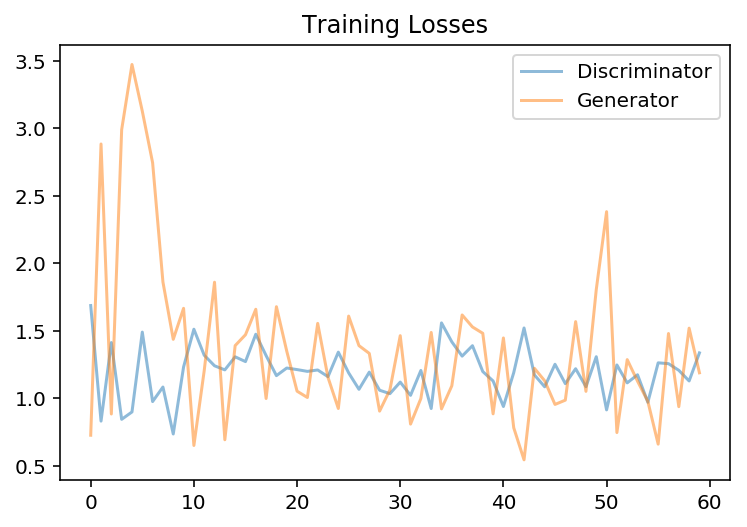

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend();

In [24]:
# sample_mean_loss = losses.T[1][30:200].mean()  # 2019-04-16T14:23:36  4.241
begin = 5
end = 25
sample_mean_loss = losses.T[1][begin:end].mean()
print(f'Sample mean generator loss = {sample_mean_loss}')

Sample mean generator loss = 1.4735460370779037


In [25]:
# Save the model
save_path = f'gan-{timestamp}.pth'

checkpoint = {'losses':       losses,
              'd_state_dict': D.state_dict(),
              'g_state_dict': G.state_dict(), 
              'd_optimizer':  d_optimizer.state_dict(),
              'g_optimizer':  d_optimizer.state_dict()}

torch.save(checkpoint, save_path)

print(f'Saved checkpoint to {save_path}')


## Load
D, G = build_network(d_conv_dim, g_conv_dim, z_size, verbose=False)
checkpoint = torch.load(save_path)

losses = checkpoint['losses']
D.load_state_dict(checkpoint['d_state_dict'])
G.load_state_dict(checkpoint['g_state_dict'])
d_optimizer.load_state_dict(checkpoint['d_optimizer'])
g_optimizer.load_state_dict(checkpoint['g_optimizer'])
print(f'Loaded checkpoint from {save_path}')

Saved checkpoint to gan-2019-04-16T16:03:52.pth
Loaded checkpoint from gan-2019-04-16T16:03:52.pth


In [ ]:
# gan-2019-04-16T14:15:39.pth  First completed

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
#     fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    fig, axes = plt.subplots(figsize=(8,8), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [35]:
# Load samples from generator, taken while training
with open(train_samples_path, 'rb') as f:
    samples = pkl.load(f)

In [38]:
# Display latest samples
if samples:
    view_samples(-1, samples);

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.